### Información utilizada:
Extraímos una muestra de 100 datos de la base de datos obtenida de la Fiscalía General de Justicia de la CDMX, para este modelo ocupamos las siguientes características:

### Diccionario de datos

|Número de variable|Nombre de la variable|Tipo de dato| Descripción|
|--|---------------------|------------|------------|
|1|mes_hecho                     | fecha       | Mes en el que ocurrió el hecho/delito.                                                                        
|2| dia_hecho                    | fecha       | Día en el que ocurrió el hecho/delito.         
|3| alcaldia_hecho                | categórico  | Alcaldía donde realmente ocurrió el hecho.                            
|4| latitud                       | continuo      | Coordenada de latitud del lugar donde ocurrió el hecho.      |
|5| longitud                      | continuo      | Coordenada de longitud del lugar donde ocurrió el hecho. |                             



Estos registros son aleatorios y fueron tomados solo de las siguientes alcaldías:

•	Iztapalapa

•	Cuauhtémoc

•	Gustavo A. Madero

•	Benito Juárez

•	Miguel Hidalgo

•	Álvaro Obregón

Esta muestra ya está limpia y no contiene valores nulos.

Nota: Las alcaldías fueron seleccionadas de esa manera porque son en las que ocurren más delitos e hicimos esa selección con el fin de delimitar los datos.


---



Carga de bibliotecas y librerías

In [82]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.metrics import r2_score

Carga de datos

In [83]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Sexto Semestre/Modelado Predictivo/examen 2/muestra100v1.csv")

In [84]:
data.tail(2)

,Unnamed: 0,anio_inicio,mes_inicio,fecha_inicio,hora_inicio,anio_hecho,mes_hecho,fecha_hecho,hora_hecho,delito,...,colonia_hecho,colonia_catalogo,alcaldia_hecho,alcaldia_catalogo,latitud,longitud,fecha_hora_hecho,dia_semana_hecho,dia_semana,conteo_delitos
98,49782,2019,ABRIL,2019-04-25,00:00:00,2019.0,4,2019-04-25,6,ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA,...,SANTIAGO ACAHUALTEPEC,PUEBLO SANTIAGO ACAHUALTEPEC,IZTAPALAPA,IZTAPALAPA,19.35281,-99.00352,2019-04-25 06:20:00,3,Thursday,1912
99,25330,2017,DICIEMBRE,2017-12-22,00:00:00,2017.0,12,2017-12-15,22,ROBO A TRANSEUNTE DE CELULAR SIN VIOLENCIA,...,VASCO DE QUIROGA,VASCO DE QUIROGA,GUSTAVO A. MADERO,GUSTAVO A. MADERO,19.49187,-99.09571,2017-12-15 22:30:00,4,Friday,1069


## Variables seleccionadas
Para SVR utilizaremos las siguientes variables:

1. latitud: ubicación geográfica de los delitos.

2. longitud: ubicación geográfica de los delitos.

3. mes_hecho: para ver cuales meses presentan un mayor número de delitos.

4. alcaldia_hecho: con esta variable podemos conocer la zona específica de la ciudad para predecir el número de delitos en determinadas zonas con diferentes niveles de ocurrencias.

5. dia_semana_hecho: para conocer los días específicos en los que ocurren los delitos, donde 0=lunes y 6=domingo

6. conteo_delitos: variable objetivo.

In [85]:
data = data.loc[:, ['latitud', 'longitud', 'dia_semana_hecho', 'mes_hecho', 'alcaldia_hecho','conteo_delitos']]

In [86]:
data

,latitud,longitud,dia_semana_hecho,mes_hecho,alcaldia_hecho,conteo_delitos
0,19.414380,-99.145220,1,7,CUAUHTEMOC,1861
1,19.381877,-99.225582,6,3,ALVARO OBREGON,769
2,19.354945,-99.009417,1,9,IZTAPALAPA,1993
3,19.512550,-99.134970,3,11,GUSTAVO A. MADERO,1190
4,19.418000,-99.157130,0,6,CUAUHTEMOC,1879
...,...,...,...,...,...,...
95,19.360298,-99.100226,1,8,IZTAPALAPA,2067
96,19.397910,-99.198640,0,8,ALVARO OBREGON,787
97,19.311540,-99.080110,5,2,IZTAPALAPA,1954
98,19.352810,-99.003520,3,4,IZTAPALAPA,1912


### Transformación de variables categóricas

In [87]:
label_encoder = LabelEncoder()
data['alcaldia_hecho_codificada'] = label_encoder.fit_transform(data['alcaldia_hecho'])

In [88]:
etiquetas = label_encoder.classes_
print(dict(zip(etiquetas, range(len(etiquetas)))))

{'ALVARO OBREGON': 0, 'BENITO JUAREZ': 1, 'CUAUHTEMOC': 2, 'GUSTAVO A. MADERO': 3, 'IZTAPALAPA': 4, 'MIGUEL HIDALGO': 5}


In [89]:
data.tail(2)

,latitud,longitud,dia_semana_hecho,mes_hecho,alcaldia_hecho,conteo_delitos,alcaldia_hecho_codificada
98,19.35281,-99.00352,3,4,IZTAPALAPA,1912,4
99,19.49187,-99.09571,4,12,GUSTAVO A. MADERO,1069,3


In [90]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   latitud                    100 non-null    float64
 1   longitud                   100 non-null    float64
 2   dia_semana_hecho           100 non-null    int64  
 3   mes_hecho                  100 non-null    int64  
 4   alcaldia_hecho             100 non-null    object 
 5   conteo_delitos             100 non-null    int64  
 6   alcaldia_hecho_codificada  100 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 5.6+ KB


In [91]:
data = data.loc[:, ['latitud', 'longitud', 'dia_semana_hecho', 'mes_hecho', 'alcaldia_hecho_codificada','conteo_delitos']]

## Modelo

### Definición de variables

In [92]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [93]:
X.head()

,latitud,longitud,dia_semana_hecho,mes_hecho,alcaldia_hecho_codificada
0,19.414380,-99.145220,1,7,2
1,19.381877,-99.225582,6,3,0
2,19.354945,-99.009417,1,9,4
3,19.512550,-99.134970,3,11,3
4,19.418000,-99.157130,0,6,2


In [94]:
print(y)

0     1861
1      769
2     1993
3     1190
4     1879
      ... 
95    2067
96     787
97    1954
98    1912
99    1069
Name: conteo_delitos, Length: 100, dtype: int64


### División de conjunto de entrenamiento y de prueba

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state = 39)

In [96]:
print(y_test)

22     835
53    1879
84    1999
57    1879
87     889
58     757
29    1997
21    2040
85    2175
79     924
24    1063
55    1997
60    2067
51     778
32     821
39     847
6      773
50    1997
94    1861
15    2122
Name: conteo_delitos, dtype: int64


Escalamiento

In [97]:
sc_X = StandardScaler()
X_train_scaled = sc_X.fit_transform(X_train[['latitud', 'longitud', 'dia_semana_hecho', 'mes_hecho', 'alcaldia_hecho_codificada']])
X_test_scaled = sc_X.transform(X_test[['latitud', 'longitud', 'dia_semana_hecho', 'mes_hecho', 'alcaldia_hecho_codificada']])
sc_y = StandardScaler()
y_train_scaled = sc_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()

In [98]:
print(X_train)

      latitud   longitud  dia_semana_hecho  mes_hecho  \
26  19.337320 -99.042770                 3          8   
99  19.491870 -99.095710                 4         12   
74  19.401370 -99.182220                 4          6   
38  19.433250 -99.147680                 4         12   
27  19.494800 -99.128200                 3          3   
..        ...        ...               ...        ...   
70  19.420380 -99.163770                 0          7   
20  19.433100 -99.140930                 2         11   
64  19.384073 -99.215743                 1          8   
41  19.438421 -99.155354                 3         11   
9   19.425450 -99.165220                 5          8   

    alcaldia_hecho_codificada  
26                          4  
99                          3  
74                          5  
38                          2  
27                          3  
..                        ...  
70                          2  
20                          2  
64                         

### Entrenar modelo

In [99]:
model = SVR(kernel='poly', degree=2)
model.fit(X_train_scaled, y_train_scaled)

SVR(degree=2, kernel='poly')

### Predicción

In [100]:
y_pred_scaled = model.predict(X_test_scaled)

In [101]:
y_pred_original = sc_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

In [102]:
y_pred_original

array([ 743.28950828, 1777.08102157, 1893.26839303, 1868.12302702,
        901.25451938, 1667.31601143, 2194.47205451, 2022.04576628,
       2049.34254291, 1357.49789188, 1507.9178332 , 2010.73568913,
       1833.62290154,  855.11329953,  500.39711979, 1166.63368833,
       1614.78281963, 2116.50594007, 1771.45410744, 2093.65365215])

In [103]:
print(y_test)

22     835
53    1879
84    1999
57    1879
87     889
58     757
29    1997
21    2040
85    2175
79     924
24    1063
55    1997
60    2067
51     778
32     821
39     847
6      773
50    1997
94    1861
15    2122
Name: conteo_delitos, dtype: int64


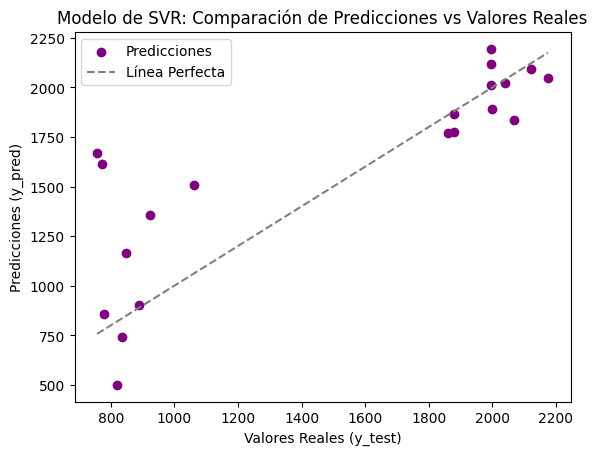

In [104]:
plt.scatter(y_test, y_pred_original, color='purple', label="Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='gray', linestyle='--', label="Línea Perfecta")
plt.title('Modelo de SVR: Comparación de Predicciones vs Valores Reales')
plt.xlabel('Valores Reales (y_test)')
plt.ylabel('Predicciones (y_pred)')
plt.legend()
plt.show()

En esta gráfica se puede ver la relación que tiene la predicción con el valor real, que serían los y_test, algunos puntos se acercan a la línea graficada y esto representa que son predicciones que estuvieron cerca del valor real, es decir, fue una buena predicción.

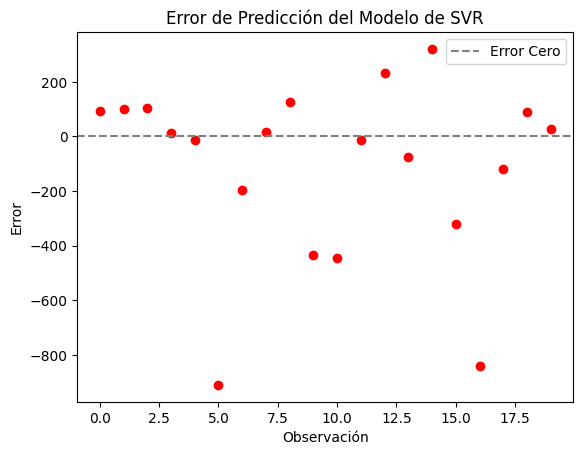

In [105]:
error = y_test - y_pred_original
plt.scatter(range(len(y_test)), error, color='red')
plt.axhline(y=0, color='gray', linestyle='--', label="Error Cero")
plt.title('Error de Predicción del Modelo de SVR')
plt.xlabel('Observación')
plt.ylabel('Error')
plt.legend()
plt.show()

Por otra parte, en este gráfico de errores, podemos ver cuanto fue por lo que se alejó una predicción del valor que se suponía que debía tomar. Por ejemplo, para la observación 6, se ve que está muy alejada del error igual a 0 (la línea negra) y esto lo podemos corroborar fácilmente pues la predicción dio un valor de 1667 y el valor real tenía 757 delitos, por lo que efectivamente, esta predicción estuvo muy alejada de la realidad.

Sin embargo, para la observación 4, la predicción fue de 1868 y el valor real fue de  1879, esta predicción fue más acertada y podemos ver que el punto que corresponde a esa observación está muy cerca del error 0.

In [106]:
mse_or = np.mean((y_test- y_pred_original) ** 2)
print("MSE original:", mse_or)
rmse_or= np.sqrt(mse_or)
print("RMSE:", rmse_or) # esta en la misma escala que los datos "originales"

MSE original: 114857.73603502606
RMSE: 338.9066774718758


Tenemos un RMSE de 338.91, así que con la siguiente parte del examen buscaremos reducir esta métrica.

# Regularización
## Sin CV
### Parámetros
* degree: representa el grado del kernel, si es muy alto su valor puede haber sobreajuste.

* C: si su valor es alto, no permite tanto error en las predicciones, pero esto aumenta la probabilidad de que se sobreajuste el modelo, pero si el valor es bajo, el modelo sería más simple y permitirá más error.

* epsilon: entre más pequeño más sobreajuste, lo que hace es que cuando asignamos un valor alto, el modelo será menos preciso al predecir, pues permite más margen de error.

* coef: es una constante que se suma a la ecuación producida por el polinomio, si este valor es alto no captura bien una relación que guarda cierta linealidad.

* gamma: cuando gamma es alto puede ser que el modelo se sobreajuste y al mismo tiempo esto permite que haya mas corvatura dentro del modelo.

In [107]:
modelR = SVR(kernel='poly', degree=2, C=0.18, epsilon=0.5, coef0=5, gamma=1.5)
modelR.fit(X_train_scaled, y_train_scaled)

SVR(C=0.18, coef0=5, degree=2, epsilon=0.5, gamma=1.5, kernel='poly')

### Predicción

In [108]:
y_pred_scaled = modelR.predict(X_test_scaled)

In [109]:
y_pred_original = sc_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

In [110]:
y_pred_original

array([ 889.19989294, 1593.33016091, 2318.54791258, 1739.80453389,
        979.9188567 , 1422.26332369, 2356.22283512, 1899.65562054,
       2148.72083868,  971.51271981, 1360.51288278, 1983.77375516,
       1904.75784994,  882.87795803,  708.07651614,  845.08632483,
       1335.28540893, 2054.15335375, 1504.86291462, 1955.20265356])

In [111]:
print(y_test)

22     835
53    1879
84    1999
57    1879
87     889
58     757
29    1997
21    2040
85    2175
79     924
24    1063
55    1997
60    2067
51     778
32     821
39     847
6      773
50    1997
94    1861
15    2122
Name: conteo_delitos, dtype: int64


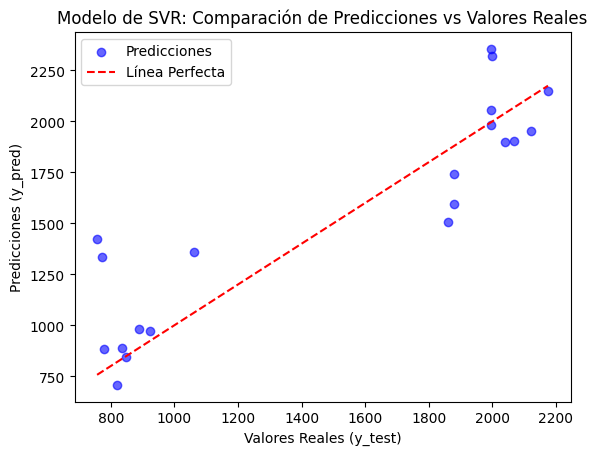

In [112]:
plt.scatter(y_test, y_pred_original, color='blue', alpha=0.6, label="Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Línea Perfecta")
plt.title('Modelo de SVR: Comparación de Predicciones vs Valores Reales')
plt.xlabel('Valores Reales (y_test)')
plt.ylabel('Predicciones (y_pred)')
plt.legend()
plt.show()

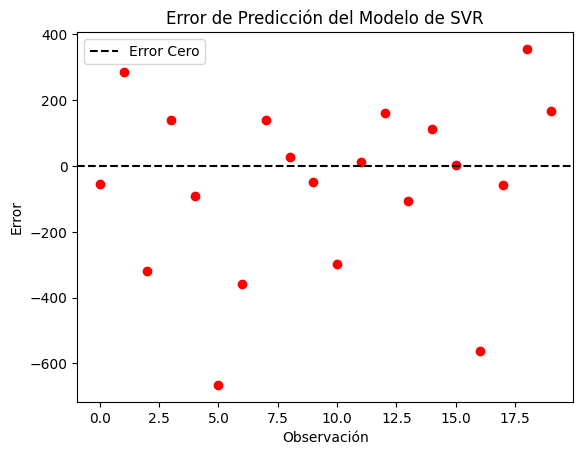

In [113]:
error = y_test - y_pred_original
plt.scatter(range(len(y_test)), error, color='red')
plt.axhline(y=0, color='black', linestyle='--', label="Error Cero")
plt.title('Error de Predicción del Modelo de SVR')
plt.xlabel('Observación')
plt.ylabel('Error')
plt.legend()
plt.show()

In [114]:
mse_or = np.mean((y_test- y_pred_original) ** 2)
print("MSE original:", mse_or)
rmse_or= np.sqrt(mse_or)
print("RMSE:", rmse_or) # esta en la misma escala que los datos "originales"

MSE original: 71070.53969373864
RMSE: 266.5905844056362


Esta fue la mejor configuración a la que llegamos para obtener un RMSE de 266.60

## Con CV

In [115]:
parametros = {
    'C': [0.1, 0.2, 0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3],
    'epsilon': [0.3, 0.5, 0.7,0.9],
    'gamma': ['scale', 0.1, 0.5, 0.8, 1, 1.2, 1.5,2],
    'degree': [2,3],
    'coef0': [1, 5, 10]
}
svr = SVR(kernel='poly')
grid_search = GridSearchCV(estimator=svr, param_grid=parametros, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=10, estimator=SVR(kernel='poly'),
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1,
                               2, 3],
                         'coef0': [1, 5, 10], 'degree': [2, 3],
                         'epsilon': [0.3, 0.5, 0.7, 0.9],
                         'gamma': ['scale', 0.1, 0.5, 0.8, 1, 1.2, 1.5, 2]},
             scoring='neg_mean_squared_error')

In [116]:
modelCV = SVR(C=0.6, coef0=1, degree=2, epsilon=0.3, gamma=1.2, kernel='poly')
modelCV.fit(X_train_scaled, y_train_scaled)

SVR(C=0.6, coef0=1, degree=2, epsilon=0.3, gamma=1.2, kernel='poly')

In [117]:
y_pred_scaled = modelCV.predict(X_test_scaled)

In [118]:
y_pred_original = sc_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

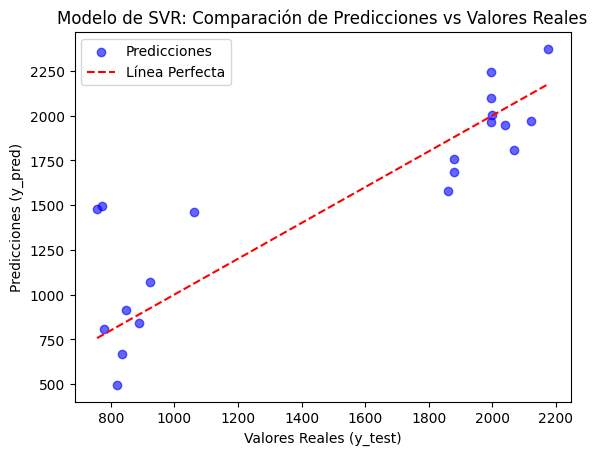

In [119]:
plt.scatter(y_test, y_pred_original, color='blue', alpha=0.6, label="Predicciones")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Línea Perfecta")
plt.title('Modelo de SVR: Comparación de Predicciones vs Valores Reales')
plt.xlabel('Valores Reales (y_test)')
plt.ylabel('Predicciones (y_pred)')
plt.legend()
plt.show()

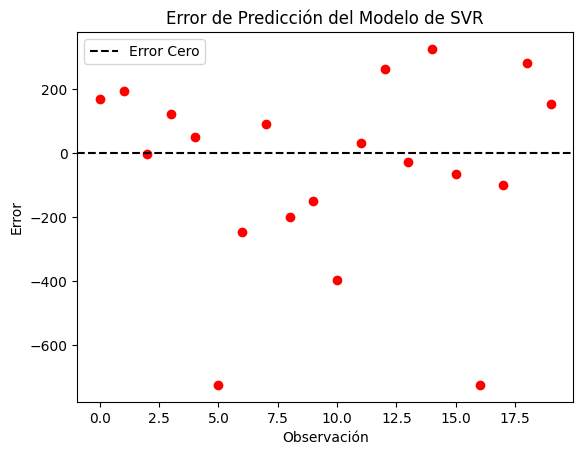

In [120]:
error = y_test - y_pred_original
plt.scatter(range(len(y_test)), error, color='red')
plt.axhline(y=0, color='black', linestyle='--', label="Error Cero")
plt.title('Error de Predicción del Modelo de SVR')
plt.xlabel('Observación')
plt.ylabel('Error')
plt.legend()
plt.show()

In [121]:
mse_or = np.mean((y_test- y_pred_original) ** 2)
print("MSE original:", mse_or)

MSE original: 85272.18743022344


In [122]:
rmse_or= np.sqrt(mse_or)
print("RMSE:", rmse_or) # esta en la misma escala que los datos "originales"

RMSE: 292.01401923576105


Como usamos validación cruzada, pudimos evaluar el rendimiento del modelo en diferentes folds de los datos y también se probaron varias configuraciones de los parametros.

Aunque se obtuvo un RMSE más alto que el que obtuvimos sin CV, puede ser debido a que como hace cv, digamos que generaliza más, a pesar de tener ligeramente un aumento en el RMSE.